In [1]:
import argparse
import os

import torch
import torch.utils.data

import model.transformer
import model.trainer as trainer
import utils.datasets
import utils.utils
import utils.plots as plots
import utils.counting as counting
import torchvision
import numpy as np
import warnings
from matplotlib import pyplot as plt

import utils.anchors
import cv2

import time
import pandas as pd

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import rasterio as rio
import json

root = 'E:/Experiments/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load model

In [2]:
model_dir = root+'testing/best.pt'# PATH TO WEIGHTS OF THE MODEL
n_model = 128 #256 for small and 512 for medium
num_blks = 1 #1 for small and 2 for medium

import model.transformer
model = model.transformer.TransformerObjectDetection(224, N_channels=3, n_model=n_model, num_blks=num_blks, 
                                                     obj = 'cbbox', device=device, bitNet=True).to(device)
checkpoint = torch.load(model_dir, map_location=torch.device(device))
if type(checkpoint) == dict:
    model.load_state_dict(checkpoint['model'])
else:
    model.load_state_dict( checkpoint )
print("Model loaded")

Model loaded


## Load test image

In [24]:
from tifffile import imread

image = imread(root+'testing/TEST IMAGES/1014.tif')#sample image with multispectral data
image = (torch.Tensor(image[..., 0:3]).permute(2, 0, 1).unsqueeze(0)).to(device) #formating for input to the model
image.shape

torch.Size([1, 3, 224, 224])

## Inference on test image

In [25]:
diou_thr = 0.5
conf_thr = 0.4
boxes, scores, classes,_ = utils.counting.inference(model,image, 'cbbox', conf_thr, diou_thr)
image = image[0]
boxes = boxes[0]
scores = scores[0]

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

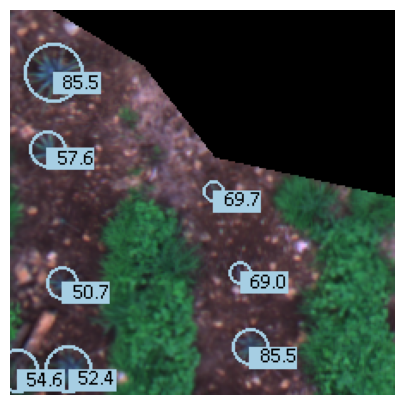

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import rasterio as rio

# bounding box colormap
cmap = np.array(plt.colormaps.get_cmap('Paired').colors)
cmap_rgb: list = np.multiply(cmap, 255).astype(np.int32).tolist()
plt.figure(figsize=(5, 5))

img = 255*image[0:3,...]/image[0:3,...].max()
img = Image.fromarray(np.asarray((img.permute(1, 2, 0))[:,:,[2,1,0]].cpu()).astype('uint8'))
draw = ImageDraw.Draw(img)

if boxes is not None:

    for box, score in zip(boxes, scores):
        # bounding box color 설정
        color = tuple(cmap_rgb[int(0) % len(cmap_rgb)])
        xc, yc, r = box
        obj_conf = score
        draw.ellipse((xc-r, yc-r, xc+r, yc+r), outline=color, width=2)
        
        # label
        text = '{} {:.1f}'.format(" ", score * 100)
        font = ImageFont.truetype('calibri.ttf', size=12)
        text_width, text_height = 27, 12 #font.getsize(text)
        draw.rectangle(((xc, yc), (xc + text_width, yc + text_height)), fill=color)
        draw.text((xc, yc), text, fill=(0, 0, 0), font=font)

plt.imshow(img); plt.axis('off')
#plt.savefig(folder_save_results+'detections.png', format="png", dpi=400)

## Test of small fraction of orthophoto

In [21]:
map_dir = 'TEST IMAGES/TEST_orthomap.tif'

imgnp = counting.read_orthomap_full(map_dir)
print("Orthomap full read")

img_size = 224
conf_thr = 0.4 #filter scores to consider only predictions with confidence score greater than conf_thr
iou_thr = 0.5
diou_thr = 0.5

Orthomap read at TEST IMAGES/TEST_orthomap.tif
Orthomap full read


In [22]:
#get all detections and filtered detection from the model
result = counting.get_boxes_map(model, imgnp, 'bgr', 'cbbox', conf_thr, iou_thr, diou_thr, img_size, device, nms=False)
imgnp, all_boxes, all_scores, all_categories, boxes_filtered, scores_filtered, classes_filtered, n_pars, n_size_mb, time_avg_pred, obj = result

Map loaded: (3, 448, 448)
 Tile  336: 447,  336: 447, Objects Detected:     4, im_shape   1   3 224 224, t:15.62
All boxes detected: 148
Boxes filtered detected: 48


(np.float64(-0.5), np.float64(447.5), np.float64(447.5), np.float64(-0.5))

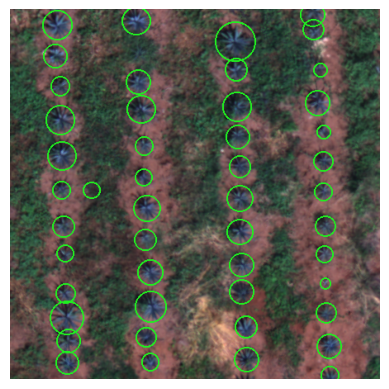

In [23]:
image = 255*imgnp[0:3,...]/imgnp[0:3,...].max()
image = Image.fromarray(np.asarray((image.transpose(1, 2, 0))[:,:,[2,1,0]]).astype('uint8'))

color = (32, 240, 32)
draw = ImageDraw.Draw(image)

for box, score in zip(boxes_filtered, scores_filtered):
    # bounding box color 설정

    xc, yc, r = box
    obj_conf = score
    draw.ellipse((xc-r, yc-r, xc+r, yc+r), outline=color, width=2)

plt.imshow(np.array(image))
plt.axis('off')
#plt.savefig(folder_save_results+'nms_example.png', format="png", dpi=400)